In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import sklearn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
import keras
from keras.activations import relu, linear
from keras.callbacks import EarlyStopping
from keras.optimizers import *
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential

In [2]:
spark = SparkSession.builder\
                    .master("local")\
                    .appName("appName")\
                    .config("Some.spark.option.config","somevalue")\
                    .getOrCreate()

In [3]:
df = spark.read.format('csv').option('header','true').load('C:\\Arunava Docs\\Pyspark Resourse\\ML\\Apple\\apple_share_price.csv')

In [4]:
df.show(3)

+---------+------+------+------+------+--------+
|     Date|  Open|  High|   Low| Close|  Volume|
+---------+------+------+------+------+--------+
|11-Aug-17| 156.6|158.57|156.07|157.48|26257096|
|10-Aug-17| 159.9|   160|154.63|155.32|40804273|
|09-Aug-17|159.26|161.27|159.11|161.06|26131530|
+---------+------+------+------+------+--------+
only showing top 3 rows


In [5]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)



In [6]:
rows = df.count()
cols = len(df.columns)
print("Rows: ",rows)
print("Columns: ",cols)

Rows:  1664
Columns:  6


In [7]:
df = df.drop_duplicates()

In [8]:
rows = df.count()
cols = len(df.columns)
print("Rows: ",rows)
print("Columns: ",cols)

Rows:  1664
Columns:  6


##### Column Casting

In [9]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)



In [10]:
df = df.withColumn('Date',to_date('Date', 'dd-MMM-yy'))
df = df.withColumn('Open',col('Open').cast('float'))
df = df.withColumn('High',col('High').cast('float'))
df = df.withColumn('Low',col('Low').cast('float'))
df = df.withColumn('Close',col('Close').cast('float'))
df = df.withColumn('Volume',col('Volume').cast('float'))

In [11]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)



In [12]:
df.show(2)

+----------+------+------+------+------+-----------+
|      Date|  Open|  High|   Low| Close|     Volume|
+----------+------+------+------+------+-----------+
|2017-03-03|138.78|139.83|138.59|139.78| 2.157112E7|
|2016-12-02|109.17|110.09|108.85| 109.9|2.6527996E7|
+----------+------+------+------+------+-----------+
only showing top 2 rows


## EDA

In [13]:
min_date = df.select(min("Date")).collect()[0][0]
max_date = df.select(max("Date")).collect()[0][0]
print("Start date: ", min_date)
print("Ending date: ", max_date)

Start date:  2011-01-03
Ending date:  2017-08-11


In [14]:
print("Staring Date of this Stock")
starting = df.filter(df["date"] == min_date)
starting.show()
print("Ending Date of this Stock")
ending = df.filter(df["date"] == max_date)
ending.show()

Staring Date of this Stock
+----------+-----+-----+-----+-----+-----------+
|      Date| Open| High|  Low|Close|     Volume|
+----------+-----+-----+-----+-----+-----------+
|2011-01-03|46.52|47.18|46.41|47.08|1.1128041E8|
+----------+-----+-----+-----+-----+-----------+

Ending Date of this Stock
+----------+-----+------+------+------+-----------+
|      Date| Open|  High|   Low| Close|     Volume|
+----------+-----+------+------+------+-----------+
|2017-08-11|156.6|158.57|156.07|157.48|2.6257096E7|
+----------+-----+------+------+------+-----------+



In [15]:
print("Which Day Had the Highest High in Stock History?")
highest_high = df.select(max("High")).collect()[0][0]
high = df.filter(df['high'] == highest_high)
high.show()

Which Day Had the Highest High in Stock History?
+----------+-----+------+------+------+-----------+
|      Date| Open|  High|   Low| Close|     Volume|
+----------+-----+------+------+------+-----------+
|2017-08-08|158.6|161.83|158.27|160.08|3.6205896E7|
+----------+-----+------+------+------+-----------+



In [16]:
print("Which Day Had the Lowest Low in Stock History?")
lowest_low = df.select(min("Low")).collect()[0][0]
low = df.filter(df['Low'] == lowest_low)
low.show()

Which Day Had the Lowest Low in Stock History?
+----------+-----+-----+-----+-----+-----------+
|      Date| Open| High|  Low|Close|     Volume|
+----------+-----+-----+-----+-----+-----------+
|2011-06-20|45.34|45.39|44.36|45.05|1.6016128E8|
+----------+-----+-----+-----+-----+-----------+



In [17]:
print("Which Day Had the Maximum Close?")
close_high = df.select(max('Close')).collect()[0][0]
close = df.filter(df['Close'] == close_high)
close.show()

Which Day Had the Maximum Close?
+----------+------+------+------+------+----------+
|      Date|  Open|  High|   Low| Close|    Volume|
+----------+------+------+------+------+----------+
|2017-08-09|159.26|161.27|159.11|161.06|2.613153E7|
+----------+------+------+------+------+----------+



In [18]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)



## Plots

In [19]:
df = df.withColumn('Year', year(col('Date')))

In [20]:
df_pd = df.drop('date').toPandas()
df_pd.corrwith(df_pd['Close'])

Open      0.999145
High      0.999601
Low       0.999626
Close     1.000000
Volume   -0.584991
Year      0.861119
dtype: float64

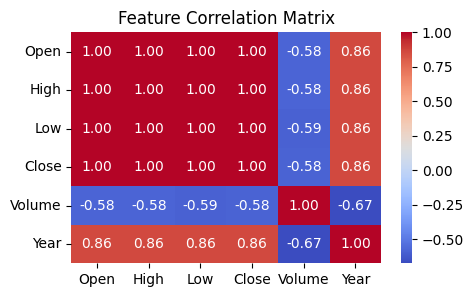

In [21]:
Cor = df_pd.corr()
plt.figure(figsize=(5,3))
sns.heatmap(Cor, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [22]:
AvgByYear = df.groupBy(df['Year']).agg(round(avg(df['Close']),2).alias('Avg Price')).orderBy('Year').show()
MaxByYear = df.groupBy(df['Year']).agg(round(max(df['Close']),2).alias('Max Price')).orderBy('Year').show()

+----+---------+
|Year|Avg Price|
+----+---------+
|2011|     52.0|
|2012|    82.29|
|2013|    67.52|
|2014|    92.26|
|2015|   120.04|
|2016|    104.6|
|2017|   141.95|
+----+---------+

+----+---------+
|Year|Max Price|
+----+---------+
|2011|    60.32|
|2012|    100.3|
|2013|    81.44|
|2014|    119.0|
|2015|    133.0|
|2016|   118.25|
|2017|   161.06|
+----+---------+



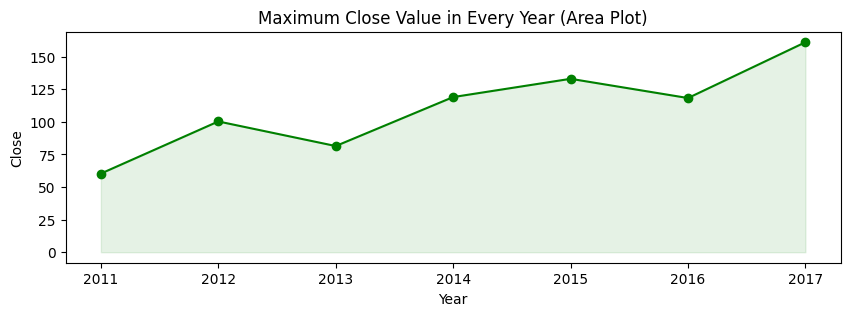

In [23]:
MaxByYear = df.groupBy(df['Year']).agg(round(max(df['Close']),2).alias('Max Price')).orderBy('Year')
MaxByYear=MaxByYear.toPandas()
fig = plt.figure(figsize=(10,3))
plt.fill_between(MaxByYear['Year'], MaxByYear['Max Price'],color = 'g', alpha=0.1)
plt.plot(MaxByYear['Year'], MaxByYear['Max Price'],color = 'g', marker='o')

plt.title("Maximum Close Value in Every Year (Area Plot)")
plt.xlabel("Year")
plt.ylabel("Close")
plt.show()

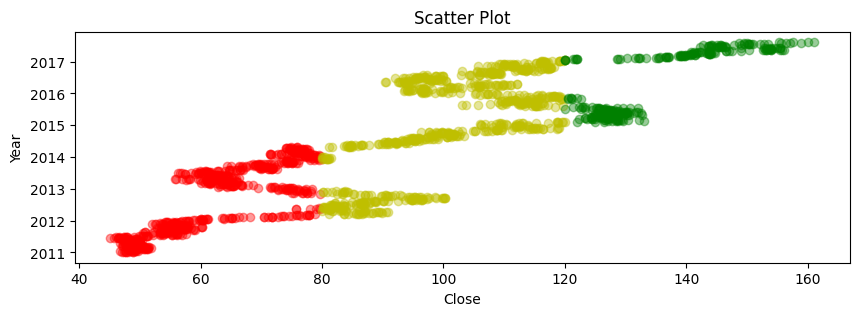

In [24]:
df_high = df.filter(df["Close"] >= 120).toPandas()
df_mid = df.filter((df["Close"] > 80) & (df["Close"] < 120)).toPandas()
df_low = df.filter(df["Close"] <= 80).toPandas()

fig=plt.figure(figsize=(10,3))
plt.scatter(df_low['Close'], df_low['Date'], color='r', alpha=0.4)
plt.scatter(df_mid['Close'], df_mid['Date'], color='y', alpha=0.4)
plt.scatter(df_high['Close'], df_high['Date'], color='g', alpha=0.4)
plt.title("Scatter Plot")
plt.xlabel("Close")
plt.ylabel("Year")
plt.show()

### Separate 20 records for testing

In [25]:
#Pandas
# Randomly select 20 rows
df_test = df_pd.sample(n=20, random_state=42)

# Store the remaining rows
df_pd = df_pd.drop(df_test.index)

In [26]:
df.head(1)

[Row(Date=datetime.date(2017, 3, 3), Open=138.77999877929688, High=139.8300018310547, Low=138.58999633789062, Close=139.77999877929688, Volume=21571120.0, Year=2017)]

## Encoding

In [27]:
X = df_pd.drop(['Close'], axis=1)
Y = df_pd['Close']

In [28]:
t = ColumnTransformer(transformers = [
    ('t1', MinMaxScaler(),
    ['Open','High','Low','Volume','Year'])
], remainder='passthrough')
x=t.fit_transform(X)
y=np.array(Y)

## Split

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print("Overall ->")
print(x.shape)
print(y.shape)
print("Training Set ->")
print(x_train.shape)
print(y_train.shape)
print("Validation Set ->")
print(x_val.shape)
print(y_val.shape)

Overall ->
(1644, 5)
(1644,)
Training Set ->
(1315, 5)
(1315,)
Validation Set ->
(329, 5)
(329,)


## Train Model

In [30]:
model = keras.Sequential([
    Input(shape=(5,)),
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(1000, activation='relu'),
    Dropout(0.2),
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 500)                 │           3,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │         501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,005,001 (3.83 MB)

 Trainable params: 1,005,001 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
o = Adam(learning_rate=0.001)
model.compile(optimizer=o, loss='mae', metrics = ['r2_score'])

In [33]:
History = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size= 100,
    validation_data=(x_val, y_val),
    callbacks=EarlyStopping(patience=3, verbose=1)
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 83.4079 - r2_score: -8.6400 - val_loss: 50.2237 - val_r2_score: -2.3016
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 21.9547 - r2_score: 0.0424 - val_loss: 14.4637 - val_r2_score: 0.7100
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.9038 - r2_score: 0.8094 - val_loss: 8.3729 - val_r2_score: 0.8905
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1287 - r2_score: 0.8889 - val_loss: 5.7335 - val_r2_score: 0.9448
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.7595 - r2_score: 0.9280 - val_loss: 3.4253 - val_r2_score: 0.9751
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9819 - r2_score: 0.9478 - val_loss: 3.4353 - val_r2_score: 0.9794
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7833 - r2_score: 0.9507 - val_loss: 2.2235 - val_r2_score: 0.9883
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.2846 - r2_score: 0.9623 - val_loss: 1.7276 -

## Result Plot

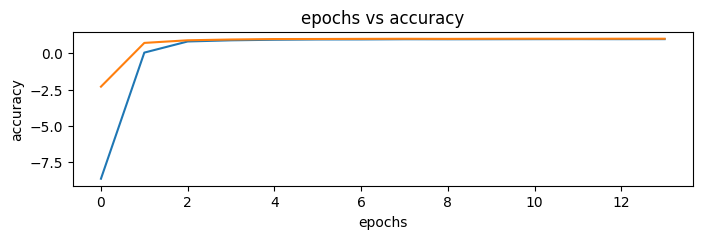

In [34]:
figsize = plt.figure(figsize=(8,2))
plt.plot(History.history['r2_score'])
plt.plot(History.history['val_r2_score'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('epochs vs accuracy')
plt.show()

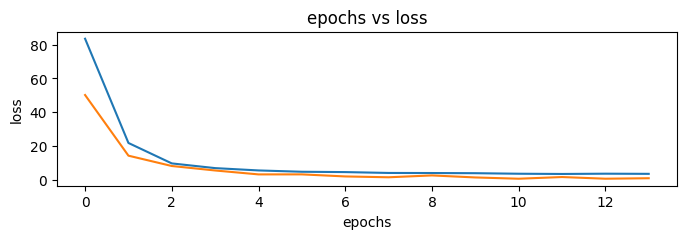

In [35]:
figsize = plt.figure(figsize=(8,2))
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('epochs vs loss')
plt.show()

## Class and Prediction

In [36]:
class ModelWrapper():
    def __init__(self, model, transformer):
        self.model = model
        self.transformer = transformer
    def predicto(self,df):
        X = df.drop(['Close'], axis=1)
        x = self.transformer.transform(X)
        y = self.model.predict(x)
        y=np.array(y)
        return y
    def evaluateo(self,df):
        return self.model.evaluate(x,y)
    
MyModel = ModelWrapper(model,t)      

In [37]:
MyModel.predicto(df_test).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


array([ 84.49459 , 125.625786,  56.802746, 131.02733 ,  52.496075,
        85.95584 ,  85.316414, 126.305916, 100.965996,  87.975525,
       107.06104 ,  49.02261 , 150.93199 ,  82.80256 ,  83.62075 ,
        85.475464,  51.02479 ,  57.19617 ,  52.923893,  87.70802 ],
      dtype=float32)

In [38]:
MyModel.evaluateo(df_test)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1495 - r2_score: 0.9974


[1.149507999420166, 0.9974053502082825]

In [39]:
#-------------------------------------------------------------END -----------------------------------------------------------